# Portfolio Optimization with QAOA

## Disclaimer
This notebook contains adaptations from IBM Qiskit Optimization Tutorials.
Original tutorial: https://qiskit-community.github.io/qiskit-optimization/tutorials/08_cvar_optimization.html

Modified by Colin Farley (2025) for benchmarking and research use at HARP Research.

## Objective
This notebook implements and evaluates the Quantum Approximate Optimization Algorithm (QAOA) on the mean-variance portfolio optimization problem, using the same problem instance and parameters as in:

- Barkoutsos et al., "Improving Variational Quantum Optimization using CVaR," *Quantum*, 4, 256 (2020)
- IBM Qiskit CVaR Optimization Tutorial

We aim to:
- Benchmark QAOA performance in isolation
- Compare with CVaR-enhanced VQE (SamplingVQE)
- Provide a modular foundation for future experiments: Warm-started QAOA, Quantum Annealing, and Classical Heuristics

# Problem Formulation

We will be using the same data and set up from the **sampling_vqe_cvar** example that is used in both qiskit_optimization and Barkoutsos et al.

In [106]:
from experiments.cvar_portfolio.data_utils import load_default_portfolio
from experiments.cvar_portfolio.objective_portfolio import portfolio_to_qp

mu, sigma = load_default_portfolio()
qp = portfolio_to_qp(mu, sigma, 0.5)
print(qp.prettyprint())

Problem name: portfolio_optimization

Maximize
  -0.3656*x_0^2 + 0.6233*x_0*x_1 - 0.4689*x_0*x_2 + 0.5452*x_0*x_3
  + 0.0082*x_0*x_4 + 0.3809*x_0*x_5 - 1.2366*x_1^2 + 0.7538*x_1*x_2
  - 2.4659*x_1*x_3 + 0.0733*x_1*x_4 - 0.8945*x_1*x_5 - 0.57715*x_2^2
  + 1.4095*x_2*x_3 - 0.0007*x_2*x_4 + 0.4301*x_2*x_5 - 1.75335*x_3^2
  - 0.2012*x_3*x_4 - 1.0922*x_3*x_5 - 0.31155*x_4^2 - 0.1509*x_4*x_5
  - 0.4496*x_5^2 + 0.7313*x_0 + 0.9893*x_1 + 0.2725*x_2 + 0.875*x_3 + 0.7667*x_4
  + 0.3622*x_5

Subject to
  Linear constraints (1)
    x_0 + x_1 + x_2 + x_3 + x_4 + x_5 == 3  'c0'

  Binary variables (6)
    x_0 x_1 x_2 x_3 x_4 x_5



# Classical Baseline

In [107]:
from experiments.cvar_portfolio.objective_portfolio import classic_solve

classical_result = classic_solve(qp)
print(classical_result.prettyprint())

objective function value: 1.27835
variable values: x_0=1.0, x_1=1.0, x_2=0.0, x_3=0.0, x_4=1.0, x_5=0.0
status: SUCCESS


# Adding Penalty



In [108]:
from experiments.cvar_portfolio.objective_portfolio import portfolio_add_penalty

penalty = 12                                    #2 * n
qp = portfolio_add_penalty(qp, penalty)
hamiltonian, offset = qp.to_ising()  
print(hamiltonian) 
print(offset)

SparsePauliOp(['IIIIIZ', 'IIIIZI', 'IIIZII', 'IIZIII', 'IZIIII', 'ZIIIII', 'IIIIZZ', 'IIIZIZ', 'IIZIIZ', 'IZIIIZ', 'ZIIIIZ', 'IIIZZI', 'IIZIZI', 'IZIIZI', 'ZIIIZI', 'IIZZII', 'IZIZII', 'ZIIZII', 'IZZIII', 'ZIZIII', 'ZZIIII'],
              coeffs=[ 0.455025+0.j, -0.60115 +0.j,  0.378625+0.j, -0.890325+0.j,  0.15975 +0.j,
 -0.37535 +0.j,  5.844175+0.j,  6.117225+0.j,  5.8637  +0.j,  5.99795 +0.j,
  5.904775+0.j,  5.81155 +0.j,  6.616475+0.j,  5.981675+0.j,  6.223625+0.j,
  5.647625+0.j,  6.000175+0.j,  5.892475+0.j,  6.0503  +0.j,  6.27305 +0.j,
  6.037725+0.j])
18.610925000000012


In [109]:
from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import Sampler

maxiter = 100
optimizer = COBYLA(maxiter=maxiter)

sampler = Sampler()

alphas = [1.0, 0.50, 0.25]


In [ ]:
from experiments.cvar_portfolio.objective_portfolio import solve_with_qaoa

results, objectives = solve_with_qaoa(qp, sampler, optimizer, offset, alphas, reps=1)

for alpha in alphas:
    print("alpha = {}:".format(alpha))
    print(results[alpha].prettyprint())
    print()

alpha = 1.0:
objective function value: 1.2783500000000174
variable values: x_0=1.0, x_1=1.0, x_2=0.0, x_3=0.0, x_4=1.0, x_5=0.0
status: SUCCESS

alpha = 0.5:
objective function value: 1.2783500000000174
variable values: x_0=1.0, x_1=1.0, x_2=0.0, x_3=0.0, x_4=1.0, x_5=0.0
status: SUCCESS

alpha = 0.25:
objective function value: 1.2783500000000174
variable values: x_0=1.0, x_1=1.0, x_2=0.0, x_3=0.0, x_4=1.0, x_5=0.0
status: SUCCESS



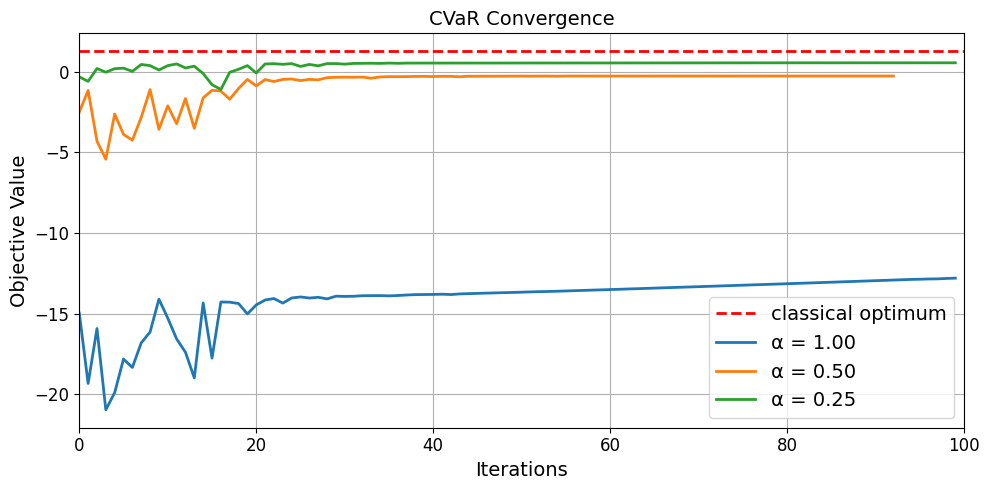

In [111]:
from experiments.cvar_portfolio.plot_cvar_history import plot_cvar_convergence

plot_cvar_convergence(
    objectives,             # dict: {alpha: [objective values per iteration]}
    classical_result.fval,  # float: classical optimum to plot as dashed line
    maxiter,                # int: max number of optimization steps
    "CVaR Convergence"      # str: optional plot title
)